# EfficientNet — czym jest i główna idea

**EfficientNet** to rodzina efektywnych sieci konwolucyjnych (CNN) zaproponowana przez **Mingxing Tan i Quoc V. Le (Google, 2019)**.  
Została stworzona, aby osiągać wysoką dokładność w zadaniach wizji komputerowej przy **znacznie mniejszych kosztach obliczeniowych** niż wcześniejsze modele (ResNet, DenseNet, Inception).

---

## 🔹 Czym jest?
- Bazowy model **EfficientNet-B0** został znaleziony za pomocą **Neural Architecture Search (NAS)**.  
- Kolejne modele (**B1–B7**) powstają poprzez **skalowanie** bazowej architektury.  
- W konstrukcji wykorzystano:
  - bloki **MBConv** (*Mobile Inverted Bottleneck Convolution*),
  - mechanizm uwagi **Squeeze-and-Excitation (SE)**.

---

## 🔹 Główna idea — *Compound Scaling*
Zamiast powiększać tylko jeden wymiar sieci (np. głębokość), EfficientNet skaluje **trzy jednocześnie**:

- **depth** → głębokość (liczba warstw),
- **width** → szerokość (liczba kanałów w warstwach),
- **resolution** → rozdzielczość obrazu wejściowego.

Skalowanie odbywa się według wzoru:

depth       = α^φ <br>
width       = β^φ <br>
resolution  = γ^φ <br>


gdzie:
- `φ` — współczynnik skali (kontroluje wielkość modelu),  
- `α, β, γ` — stałe dobrane empirycznie, aby uzyskać najlepszy balans.

---

## 🔹 Zalety
- ✅ Bardzo wysoka dokładność przy małej liczbie parametrów.  
- ✅ Możliwość wyboru modelu B0–B7 w zależności od dostępnych zasobów.  
- ✅ Dobre do transfer learningu w klasyfikacji obrazów i medycynie.  

---


In [1]:
import os
import shutil
from pathlib import Path
import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
from PIL import Image
from torchvision import models, transforms, datasets
import torch.nn.functional as F



2025-09-22 20:16:17.120411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

SEED = 900729
dir_path = './data'
train_path = './data/Training'
test_path = './data/Testing'
validation_path = './data/Validation'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(f"Devic: {device}")

if os.path.exists(dir_path):
    print("Dane juz istnieją")
else:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('masoudnickparvar/brain-tumor-mri-dataset', path='./data', unzip=True)
    tr_orginal_df = load(train_path)
    ts_df = load(test_path)
    val_df, tr_df = train_test_split(tr_orginal_df, train_size=0.25, random_state=SEED, stratify=tr_orginal_df['Class'])
    validation_path = './data/Validation'
    Path(validation_path).mkdir(exist_ok=True)

    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for class_name in classes:
        class_validation_path = Path(validation_path) / class_name
        class_validation_path.mkdir(exist_ok=True)

    errors = []

    for idx, row in val_df.iterrows():
        try:
            source_path = Path(row['Class Path'])

            filename = source_path.name
            class_name = row['Class']
            destination_path = Path(validation_path) / class_name / filename

            shutil.move(str(source_path), str(destination_path))

        except Exception as e:
            errors.append({
                'file': row['Class Path'],
                'class': row['Class'],
                'error': str(e)
            })


    if errors:
        print(f"Errors: {len(errors)}")
        for error in errors:
            print(f"  - {error['class']}: {Path(error['file']).name} - {error['error']}")

    val_df_updated = val_df.copy()
    val_df_updated['Class Path'] = val_df_updated.apply(
        lambda row: str(Path(validation_path) / row['Class'] / Path(row['Class Path']).name),
        axis=1
    )

    tr_df_updated = load(train_path)

    val_df = val_df_updated
    tr_df = tr_df_updated
    print("Pomyślnie pobrano dane")

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=data_transforms)
test_dataset  = datasets.ImageFolder(root=test_path, transform=data_transforms)
val_dataset   = datasets.ImageFolder(root=validation_path, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


Devic: cpu
Dane juz istnieją


In [3]:
model = models.efficientnet_b0(pretrained=True)
num_classes = len(train_dataset.classes)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



/home/fidok/Projects/WakacyjneWyzwanieSOLVRO_ML/FinalnyProjekt/Brain_Tumor_Team_Projekt4/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fidok/Projects/WakacyjneWyzwanieSOLVRO_ML/FinalnyProjekt/Brain_Tumor_Team_Projekt4/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
EPOCHS = 10
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accs, val_accs = [], []

if os.path.exists('best_model_EfficientNet.pth'):
    model.load_state_dict(torch.load('best_model_EfficientNet.pth'))
    print("Wczytano zapisany model")
else:
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accs.append(epoch_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} "
            f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_EfficientNet.pth')
            print(f"Zapisano nowy najlepszy model: {val_loss:.4f}")

        scheduler.step()

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Przebieg strat')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Przebieg dokładności')
    plt.legend()

    plt.show()


Wczytano zapisany model


Test Loss: 0.0388
Test Accuracy: 99.01%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.98      0.99      0.98       306
     notumor       1.00      0.99      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311


Confusion Matrix:


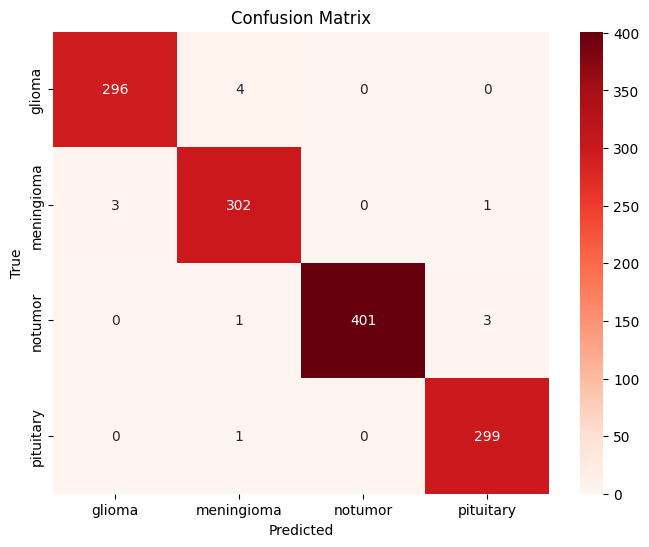

In [5]:
model.load_state_dict(torch.load('best_model_EfficientNet.pth'))

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

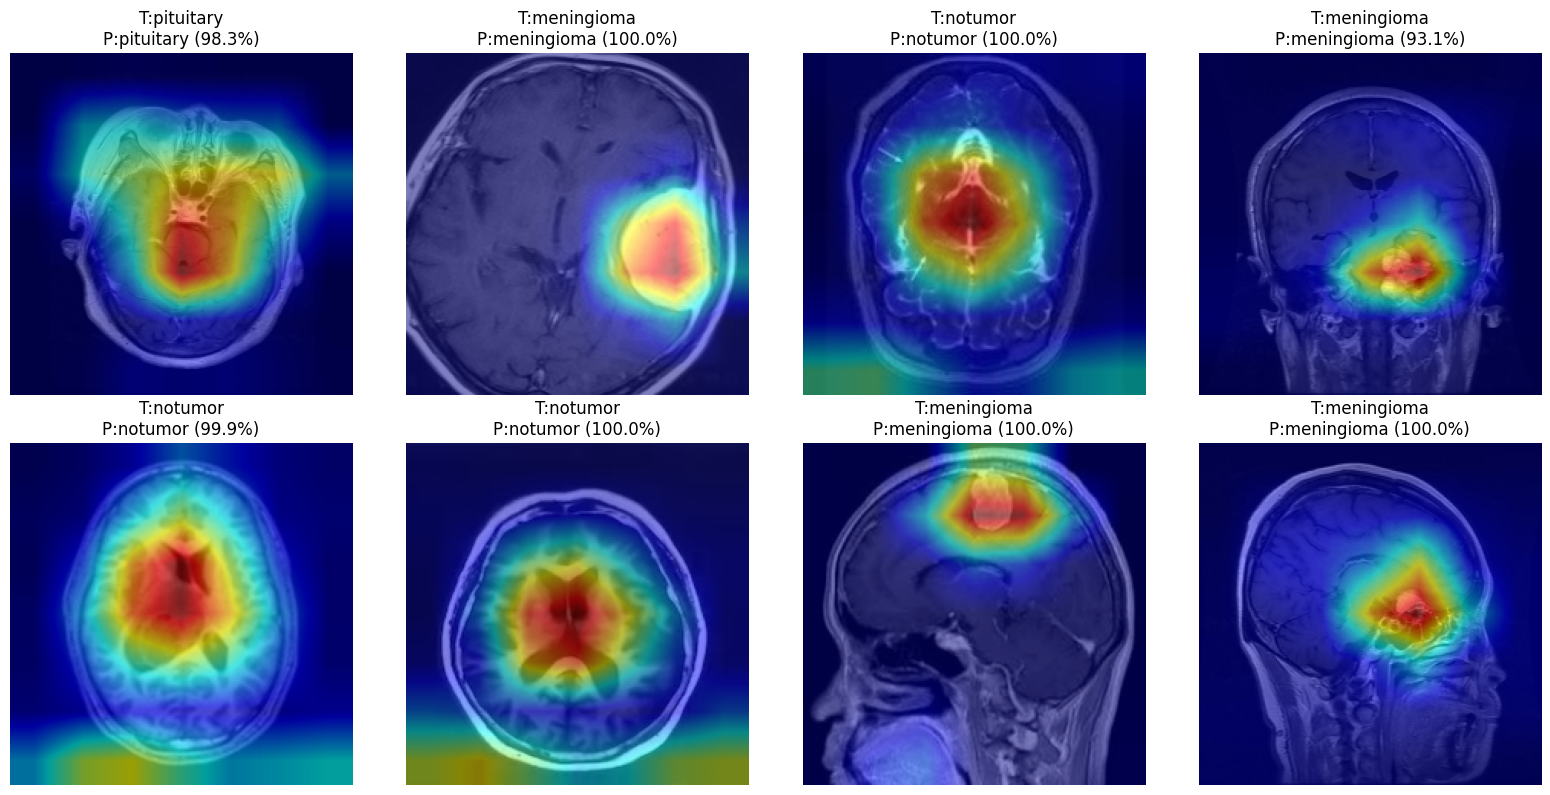

In [7]:
num_classes = len(test_dataset.classes)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load("best_model_EfficientNet.pth", map_location=device))
model.to(device)
model.eval()

#przejscie przez warstwy i wylaczenie SiLU
def recursive_set_inplace(module, inplace=False):
    for child_name, child in module.named_children():
        if isinstance(child, nn.SiLU):
            setattr(module, child_name, nn.SiLU(inplace=inplace))
        else:
            recursive_set_inplace(child, inplace)

recursive_set_inplace(model, inplace=False)

samples = random.sample(test_dataset.samples, 8)

#gradient na ostatniej warstwie cech
target_layers = [model.features[-1]]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

with GradCAM(model=model, target_layers=target_layers) as cam:
    for idx, (img_path, true_label) in enumerate(samples):
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (224, 224))
        rgb_img = np.float32(img_resized) / 255.0

        pil_img = Image.fromarray(img_resized)
        input_tensor = data_transforms(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            conf, pred_class = torch.max(probs, 1)
            pred_class = pred_class.item()
            conf = conf.item() * 100

        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        ax = axes[idx // 4, idx % 4]
        ax.imshow(visualization)
        ax.axis("off")
        ax.set_title(f"T:{test_dataset.classes[true_label]}\nP:{test_dataset.classes[pred_class]} ({conf:.1f}%)")

plt.tight_layout()
plt.show()
